In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import argparse
import os
import random
import signal
import sys
import uuid
from collections import deque

import cv2

import gym
import gym_donkeycar
import numpy as np
import tensorflow as tf
# from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed as TD
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt # debug
# logging
# from stable_baselines import logger
# from stable_baselines.common import explained_variance, tf_util, TensorboardWriter
# from stable_baselines.common.tf_util import mse, total_episode_reward_logger
import math
import datetime
img_rows, img_cols = 80, 80
# Convert image into Black and white
img_channels = 4  # We stack 4 frames

## The original CNN_LSTM model, without dropout 

In [5]:
def build_model(seq_length=4, num_outputs=15, input_shape=(80, 80)):
        img_seq_shape = (seq_length,) + input_shape + (1,)
        # img_in = Input(shape=img_seq_shape, name='img_in')
#         drop_out = 0.3

        model = Sequential()
        model.add(Input(shape=img_seq_shape, name='img_in')) # 4*80*80
        model.add(TD(Conv2D(24, (5,5), strides=(2,2), activation='relu'))) 
#         model.add(TD(Dropout(drop_out)))
        model.add(TD(Conv2D(32, (5, 5), strides=(2, 2), activation='relu')))
#         model.add(TD(Dropout(drop_out)))
        model.add(TD(Conv2D(32, (3, 3), strides=(2, 2), activation='relu')))
#         model.add(TD(Dropout(drop_out)))
        model.add(TD(Conv2D(32, (3, 3), strides=(1, 1), activation='relu')))
#         model.add(TD(Dropout(drop_out)))
        model.add(TD(MaxPooling2D(pool_size=(2, 2))))
        model.add(TD(Flatten(name='flattened')))
        model.add(TD(Dense(100, activation='relu')))
#         model.add(TD(Dropout(drop_out)))
        
        model.add(LSTM(128, return_sequences=True, name="LSTM_seq"))
#         model.add(Dropout(.1))
        model.add(LSTM(128, return_sequences=False, name="LSTM_fin"))
#         model.add(Dropout(.1))
        model.add(Dense(128, activation='relu'))
#         model.add(Dropout(.1))
        model.add(Dense(64, activation='relu'))
#         model.add(Dense(10, activation='relu'))
        model.add(Dense(num_outputs, activation='linear', name='model_outputs'))

        model.compile(optimizer="rmsprop", loss='mse')

        return model

In [6]:
model = build_model()

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, 4, 38, 38, 24)     624       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 4, 17, 17, 32)     19232     
_________________________________________________________________
time_distributed_14 (TimeDis (None, 4, 8, 8, 32)       9248      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 4, 6, 6, 32)       9248      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 4, 3, 3, 32)       0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 4, 288)            0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 4, 100)           

## Edit the CNN_LSTM to check all dimensions are ok

In [43]:
class DQNAgent:
    def __init__(self):
        self.learning_rate = 1e-4
    def build_model(self, seq_length=4, num_outputs=15, input_shape=(80, 80)):
            img_seq_shape = (seq_length,) + input_shape + (1,)

            model = Sequential()
            model.add(Input(shape=img_seq_shape, name='img_in')) # 4*80*80*1
            model.add(TD(Conv2D(16, (5, 5), strides=(2, 2), padding="same", activation='relu'))) # can try conv3d instead of td(conv2d)
            model.add(TD(Conv2D(64, (5, 5), strides=(2, 2), padding="same", activation='relu')))
            model.add(TD(Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation='relu')))
            
            model.add(TD(GlobalAveragePooling2D()))

            model.add(LSTM(128, return_sequences=False, name="LSTM_fin"))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(num_outputs, activation='linear', name='model_outputs'))

            adam = Adam(lr=self.learning_rate)
            model.compile(loss="mse", optimizer=adam)

            return model

In [44]:
dqn_agent = DQNAgent()
model = dqn_agent.build_model()

In [45]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_38 (TimeDis (None, 4, 40, 40, 16)     416       
_________________________________________________________________
time_distributed_39 (TimeDis (None, 4, 20, 20, 64)     25664     
_________________________________________________________________
time_distributed_40 (TimeDis (None, 4, 20, 20, 128)    73856     
_________________________________________________________________
time_distributed_41 (TimeDis (None, 4, 128)            0         
_________________________________________________________________
LSTM_fin (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
model_outputs (Dense)        (None, 15)               

In [46]:
model(s_t)

<tf.Tensor: shape=(1, 15), dtype=float32, numpy=
array([[-0.3944237 ,  0.07020821, -0.37300617, -0.47973633,  0.11471912,
         0.40338793,  0.26893467, -0.13524842,  0.03075199, -0.5603358 ,
         0.60194093, -0.0122754 , -0.37381324, -0.20189273,  0.04342777]],
      dtype=float32)>

# Test the input shape for LSTM

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image

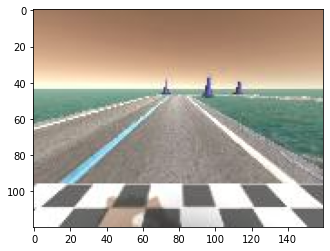

In [10]:
next_obs = cv2.imread("images/0_cam-image_array_.jpg")
plt.imshow(next_obs)

In [11]:
img_rows = 80
img_cols = 80
def rgb2gray(rgb):
    """
    take a numpy rgb image return a new single channel image converted to greyscale
    """
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def process_image(obs):
    global LANE_SEGMENTATION 
    obs = rgb2gray(obs)
    obs = cv2.resize(obs, (img_rows, img_cols))
#         print("in process_image") # debug 
#         plt.imshow(obs) # debug
#     if LANE_SEGMENTATION: obs = detect_edge(obs)
    return obs

In [12]:
x_t = process_image(next_obs)
s_t = np.stack((x_t, x_t, x_t, x_t), axis=0)
print("s_t1 shape:", s_t.shape)
# In Keras, need to reshape
s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  # 1*80*80*4
print("x_t1 shape:", x_t.shape)
print("s_t1 shape:", s_t.shape)

s_t1 shape: (4, 80, 80)
x_t1 shape: (80, 80)
s_t1 shape: (1, 4, 80, 80)


In [34]:
next_obs = cv2.imread("images/1283_cam-image_array_.jpg")
# plt.imshow(agent.process_image(next_obs)) # debug
# plt.savefig("{}.png".format(agent.t)) # debug
x_t1 = process_image(next_obs)
x_t1 = x_t1.reshape(1, 1, x_t1.shape[0], x_t1.shape[1])  # 1x1x80x80
s_t1 = np.append(x_t1, s_t[:, :3, :, :], axis=1)  # 1x4x80x80
print("x_t1 shape:", x_t1.shape)
print("s_t1 shape:", s_t1.shape)

x_t1 shape: (1, 1, 80, 80)
s_t1 shape: (1, 4, 80, 80)
